In [8]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
import itertools
import os
import os.path
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
import csv
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

warnings.simplefilter(action='ignore', category = FutureWarning)
%matplotlib inline

physical_dev = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs avail: ", len(physical_dev))
tf.config.experimental.set_memory_growth(physical_dev[0], True)
#tf.debugging.set_log_device_placement(True)



os.chdir('C:/venv/tensorflow-scripting/data/lung-scans')

CURR_DIR = os.getcwd()


#Grayscale
#Didn't really help, since normalization happens by the grayscale now.  
if os.path.isdir('train_images_grays') is False:
    os.makedirs('train_images_grays')
    with open('labels/labels_train.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            img = Image.open(CURR_DIR + '/train_images/' + row['file_name'])
            img2 = img.convert('L') 
            img2.save(CURR_DIR + '/train_images_grays/' + row['file_name'])
        



#Data org
if os.path.isdir('train/healthy') is False:
    os.makedirs('train/healthy')
    os.makedirs('train/bacterial')
    os.makedirs('train/viral')
    os.makedirs('valid/healthy')
    os.makedirs('valid/bacterial')
    os.makedirs('valid/viral')
    os.makedirs('test/healthy')
    os.makedirs('test/bacterial')
    os.makedirs('test/viral')



    '''
    class_id = 0 if the image corresponds to a subject without disease (normal)
    
    class_id = 1 if the image corresponds to a patient with bacterial pneumonia

    class_id = 2 if the image corresponds to a patient with viral pneumonia
    '''

    with open('labels/labels_train.csv', newline='') as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
#HEALTHY
            if(row['class_id'] == '0'):
                if(len([name for name in os.listdir(CURR_DIR + '/train/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/healthy/', name))]) < 1000):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/healthy/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/healthy/', name))]) < 100):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/healthy/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/healthy/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/healthy/', name))]) < 50):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/healthy/')
#BACTERIAL
            if(row['class_id'] == '1'):
                if(len([name for name in os.listdir(CURR_DIR + '/train/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/bacterial/', name))]) < 1000):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/bacterial/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/bacterial/', name))]) < 100):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/bacterial/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/bacterial/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/bacterial/', name))]) < 50):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/bacterial/')
#VIRAL                        
            if(row['class_id'] == '2'):
                if(len([name for name in os.listdir(CURR_DIR + '/train/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/train/viral/', name))]) < 1000):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/train/viral/')
                elif(len([name for name in os.listdir(CURR_DIR + '/valid/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/valid/viral/', name))]) < 100):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/valid/viral/')
                elif(len([name for name in os.listdir(CURR_DIR + '/test/viral/')
                    if os.path.isfile(os.path.join(CURR_DIR + '/test/viral/', name))]) < 50):
                    file = '/train_images_grays/' + row['file_name']
                    shutil.copy(CURR_DIR + file, CURR_DIR + '/test/viral/')                   

os.chdir('../../')


print('finished organising data')
   

Num GPUs avail:  1
finished organising data


In [2]:
train_path = 'data/lung-scans/train'
valid_path = 'data/lung-scans/valid'
test_path = 'data/lung-scans/test'

def preprocessor (xarray):
    xarray=(xarray/127.5)-1
    return xarray
# then use this function as the preprocessing function in the generator
#preprocessing_function = preprocessor



#ok, this preproc looks wack
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = train_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10)
valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = valid_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10)
test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.vgg16.preprocess_input).flow_from_directory(
    directory = test_path, target_size=(224,224), classes = ['bacterial', 'healthy', 'viral'], batch_size = 10, shuffle = False)

assert train_batches.n == 3000
assert valid_batches.n == 300
assert test_batches.n == 150
assert train_batches.num_classes == valid_batches.num_classes == test_batches.num_classes == 3

imgs, labels = next(train_batches)

def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize = (20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(imgs)
print(labels)

In [4]:

#TRAINING VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16()

#vgg16_model.summary()
#Loop through every except last vgg16 classifies 1000 classes.( we need only 3) and add them to the new model
model = Sequential()
#{'batch_input_shape': (None, 224, 224, 3), 'dtype': 'float32', 'sparse': False, 'ragged': False, 'name': 'input_2'}
#model.add(tf.keras.layers.InputLayer(input_shape = (448, 448, 3), dtype = 'float32', sparse = False, ragged = False))
for layer in vgg16_model.layers[:-1]:
    model.add(layer)
    
#model.summary()

#for layer in model.layers:
#    layer.trainable = False

model.add(Dense(units = 3, activation = 'softmax'))

#model.summary()

model.compile(optimizer = Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics = ['accuracy'])

history = model.fit(x = train_batches, validation_data = valid_batches, epochs = 10, verbose = 2)



Epoch 1/10
150/150 - 37s - loss: 0.8486 - accuracy: 0.6393 - val_loss: 0.7525 - val_accuracy: 0.6933
Epoch 2/10
150/150 - 36s - loss: 0.5981 - accuracy: 0.7403 - val_loss: 0.5632 - val_accuracy: 0.7633
Epoch 3/10
150/150 - 37s - loss: 0.5135 - accuracy: 0.7843 - val_loss: 0.5852 - val_accuracy: 0.7700
Epoch 4/10
150/150 - 37s - loss: 0.4608 - accuracy: 0.8120 - val_loss: 0.6014 - val_accuracy: 0.7433
Epoch 5/10
150/150 - 37s - loss: 0.4403 - accuracy: 0.8177 - val_loss: 0.5223 - val_accuracy: 0.7867
Epoch 6/10
150/150 - 37s - loss: 0.3834 - accuracy: 0.8373 - val_loss: 0.6094 - val_accuracy: 0.7900
Epoch 7/10
150/150 - 37s - loss: 0.3424 - accuracy: 0.8537 - val_loss: 0.6083 - val_accuracy: 0.7567
Epoch 8/10
150/150 - 37s - loss: 0.3240 - accuracy: 0.8670 - val_loss: 0.6114 - val_accuracy: 0.7667
Epoch 9/10
150/150 - 37s - loss: 0.2678 - accuracy: 0.8930 - val_loss: 0.6778 - val_accuracy: 0.7833
Epoch 10/10
150/150 - 37s - loss: 0.2084 - accuracy: 0.9187 - val_loss: 0.7321 - val_accura

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

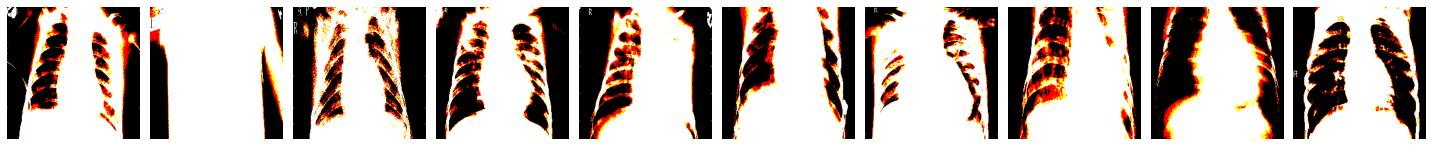

Confusion matrix, without norm
[[33  1 16]
 [ 3 43  4]
 [10  2 38]]


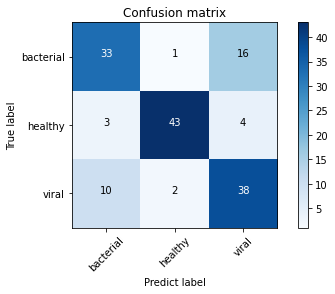

In [5]:
#PREDICTING
test_imgs, test_labels = next(test_batches)
plotImages(test_imgs)
predictions = model.predict(x=test_batches, verbose = 0)
test_batches.classes
cm = confusion_matrix(y_true = test_batches.classes, y_pred = np.argmax(predictions, axis = -1))
test_batches.class_indices
cm_plot_labels = ['bacterial', 'healthy', 'viral']




def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Cunfusion matrix',
                          cmap = plt.cm.Blues):
    """
    Prints and plots the confusion matrix.
    Normalization can be applied by setting 'normalize  = True'.
    """
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without norm")
        
    print(cm)
    
    thresh = cm.max() / 2.
    for i,j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i,j],
            horizontalalignment = "center",
            color = "white" if cm[i,j] > thresh else "black")
            
            
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predict label')

plot_confusion_matrix(cm = cm, classes = cm_plot_labels, title = 'Confusion matrix')

In [5]:
#for layer in vgg16_model.layers[:-1]:
#    print(layer)
#    print(layer.get_config())
#vgg16_model.summary()

'2.3.1'

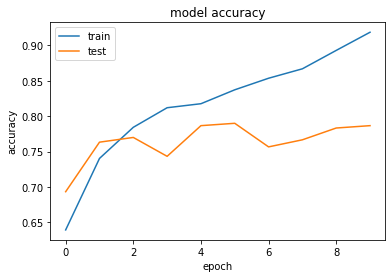

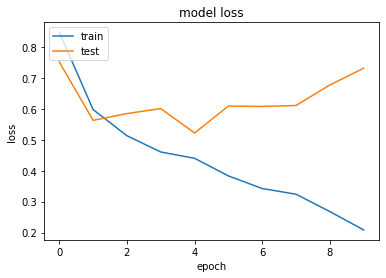

In [6]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()